In [54]:
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
import os
from collections import Counter, defaultdict
from sklearn.linear_model import Ridge, RidgeClassifier
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import make_scorer, mean_squared_error, r2_score
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
palette = sns.color_palette('tab10')
sns.set_palette(palette)
sns.set(context='notebook', style='white', rc={"font.family": "DejaVu Serif"})

# Load, format, and regress data

## Load monkey spikes and RL values, then use regression to decode values from spikes

In [6]:
def clean_paired_array_lists(list1, list2):
    if len(list1) != len(list2):
        raise ValueError("Input lists must be of equal length.")
    # Step 1: Remove pairs where list1 has NaNs
    filtered_pairs = [(a1, a2) for a1, a2 in zip(list1, list2) if not np.isnan(a1).any()]
    if not filtered_pairs:
        return [], []
    # Step 2: Find the most common shape in list1 after filtering NaNs
    shapes = [a1.shape for a1, _ in filtered_pairs]
    most_common_shape = Counter(shapes).most_common(1)[0][0]
    # Step 3: Keep only pairs where a1 has the most common shape
    cleaned_list1 = [a1 for a1, a2 in filtered_pairs if a1.shape == most_common_shape]
    cleaned_list2 = [a2 for a1, a2 in filtered_pairs if a1.shape == most_common_shape]
    return np.array(cleaned_list1), np.array(cleaned_list2)

In [81]:
def regress_spikes_values(variables=['DeltaV_Stim', 'DeltaV_Act', 'omega']):
    regression_dict = {}
    for monkey in ['V', 'W']:
        regression_dict[monkey] = {}
        for session in range(4):
            regression_dict[monkey][session] = {}
            for variable in variables:
                # print(monkey, session, variable)
                X = []
                Y = []
                for block in range(1,25):
                    for trial in range(1, 81):
                        file = f"monkey{monkey}_session{session}_block{block}_trial{trial}"
                        try:
                            x = np.load(f"data/emp/{file}_spikes_choice.npz")['spikes']
                            y = pd.read_pickle(f'data/rl/{file}_values.pkl')[variable].to_numpy()
                            X.append(x)
                            Y.append(y)
                        except:
                            pass
                X, Y = clean_paired_array_lists(X, Y)
                pipeline = make_pipeline(StandardScaler(), Ridge(alpha=1.0))
                pipeline.fit(X, Y)
                regression_dict[monkey][session][variable] = pipeline

    predictions = []
    predictions_shuffled = []
    rng = np.random.default_rng(seed=0)
    for monkey in ['V', 'W']:
        for session in range(4):
            for block in range(1, 25):
                for trial in range(1, 81):
                    row = {'monkey': monkey, 'session': session, 'block': block, 'trial': trial}
                    row_shuffled = {'monkey': monkey, 'session': session, 'block': block, 'trial': trial}
                    try:
                        file = f"monkey{monkey}_session{session}_block{block}_trial{trial}"
                        x = np.load(f"data/emp/{file}_spikes_choice.npz")['spikes']
                        xs = x.copy()
                        rng.shuffle(xs, axis=0)
                        for variable in variables:
                            model = regression_dict[monkey][session][variable]
                            y_pred = model.predict([x])[0]
                            y_pred_shuf = model.predict([xs])[0]
                            row[variable] = y_pred
                            row_shuffled[variable] = y_pred_shuf
                        predictions.append(row)
                        predictions_shuffled.append(row_shuffled)
                    except Exception:
                        pass

    monkey_values = pd.DataFrame(predictions)
    monkey_shuffled = pd.DataFrame(predictions_shuffled)
    monkey_values = monkey_values.sort_values(['monkey', 'session', 'block', 'trial']).reset_index(drop=True)
    monkey_shuffled = monkey_shuffled.sort_values(['monkey', 'session', 'block', 'trial']).reset_index(drop=True)
    monkey_values['model_type'] = 'monkey'
    monkey_shuffled['model_type'] = 'monkey'

    return monkey_values, monkey_shuffled

In [82]:
monkey_values, monkey_shuffled = regress_spikes_values()
monkey_values.to_pickle("data/monkey_values.pkl")
monkey_shuffled.to_pickle("data/monkey_shuffled.pkl")
# monkey_values = pd.read_pickle("data/monkey_values.pkl")

## Load RL values

In [84]:
def load_rl_values():
    dfs = []
    variables = ['DeltaV_Stim', 'DeltaV_Act', 'DV_left', 'DV_right', 'omega']
    columns = ['monkey', 'session', 'block', 'trial'] + variables
    regression_dict = {}
    for monkey in ['V', 'W']:
        for session in range(4):
            for block in range(1,25):
                for trial in range(1, 81):
                    file = f"monkey{monkey}_session{session}_block{block}_trial{trial}"
                    try:
                        values = pd.read_pickle(f'data/rl/{file}_values.pkl')
                        cols = [monkey, session, block, trial]
                        for var in variables:
                            cols.append(values[var].values[0])
                        dfs.append(pd.DataFrame([cols], columns=columns))
                    except:
                        pass
    rl_values = pd.concat(dfs, ignore_index=True)
    return rl_values

In [85]:
rl_values = load_rl_values()

## Add accuracy and reversal information to RL and monkey dataframes

In [86]:
emp = pd.read_pickle("data/empirical.pkl").copy()
emp['trial_rev'] = emp['trial'].astype('int64') - emp['reversal_at_trial'].astype('int64')
emp.rename(columns={'monkey_choice': 'cloc'}, inplace=True)
emp.rename(columns={'monkey_accuracy': 'acc'}, inplace=True)
emp.rename(columns={'reward': 'rew'}, inplace=True)
emp['rew'] = emp['rew'].replace(0, -1)
emp['cloc'] = emp['cloc'].replace('left', 0)
emp['cloc'] = emp['cloc'].replace('right', 1)

monkey_values = pd.merge(
    monkey_values,
    emp[["monkey", "session", "block", "trial", "block_type", "rew", "cloc", "clet", "acc", "trial_rev"]],
    # emp[["monkey", "session", "block", "trial", "block_type", "trial_rev", 'acc']],
    on=["monkey", "session", "block", "trial"],
    how="left"  # keeps all df1 rows, fills missing df2 values with NaN
)
monkey_values = monkey_values.dropna().reset_index(drop=True)

monkey_shuffled = pd.merge(
    monkey_shuffled,
    emp[["monkey", "session", "block", "trial", "block_type", "rew", "cloc", "clet", "acc", "trial_rev"]],
    # emp[["monkey", "session", "block", "trial", "block_type", "trial_rev", 'acc']],
    on=["monkey", "session", "block", "trial"],
    how="left"  # keeps all df1 rows, fills missing df2 values with NaN
)
monkey_shuffled = monkey_shuffled.dropna().reset_index(drop=True)

rl_values = pd.merge(
    rl_values,
    emp[["monkey", "session", "block", "trial", "block_type", "trial_rev"]],
    on=["monkey", "session", "block", "trial"],
    how="left"  # keeps all df1 rows, fills missing df2 values with NaN
)
rl_values['model_type'] = 'rl'

/tmp/ipykernel_2685294/3757511127.py:8: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  emp['cloc'] = emp['cloc'].replace('right', 1)


## Load NEF values

In [25]:
def load_nef_values(load=False, monkeys=['V', 'W'], sessions=range(4), blocks=range(1,25)):
    if load:
        nef_values = pd.read_pickle("data/nef_values.pkl")
    else:
        emp = pd.read_pickle("data/empirical.pkl")
        nef_dfs = []
        rl_dfs = []
        for monkey in monkeys:
            for session in sessions:
                for block in blocks:
                    try:
                        file = f"monkey{monkey}_session{session}_block{block}"
                        nef_dfs.append(pd.read_pickle(f'data/nef/{file}_values.pkl').query("perturb==0.0"))
                    except:
                        pass
        nef_values = pd.concat(nef_dfs, ignore_index=True)
        nef_values.to_pickle("data/nef_values.pkl")
    return nef_values

In [26]:
nef_values = load_nef_values(False)
nef_values['model_type'] = 'nef'
nef_values.rename(columns={'w': 'omega'}, inplace=True)
nef_values['dvs'] = nef_values['va'] - nef_values['vb']
nef_values['dva'] = nef_values['vl'] - nef_values['vr']

In [47]:
nef_values

,monkey,session,block,trial,trial_rev,block_type,perturb,va,vb,vl,...,omega,al,ar,clet,cloc,rew,acc,model_type,dvs,dva
0,V,0,1,1,-36,what,0,-0.006505,-0.001856,-0.002768,...,0.493318,-0.002977,0.073940,B,right,1,1,nef,-0.004649,-0.006172
1,V,0,1,2,-35,what,0,0.139605,0.010362,0.024906,...,0.464958,0.074045,0.182122,A,right,1,0,nef,0.129243,-0.161575
2,V,0,1,3,-34,what,0,0.123081,0.157950,0.013098,...,0.430659,0.035271,0.330782,A,right,-1,0,nef,-0.034869,-0.302142
3,V,0,1,4,-33,what,0,0.104925,0.027413,-0.007991,...,0.399681,0.034547,0.193608,A,right,1,0,nef,0.077512,-0.169859
4,V,0,1,5,-32,what,0,0.169885,0.097516,-0.011408,...,0.372923,0.039166,0.292164,B,right,1,1,nef,0.072369,-0.300898
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15195,W,3,24,76,33,where,0,0.062051,-0.110625,-0.019659,...,0.125217,-0.041706,0.249175,A,right,1,0,nef,0.172676,-0.426560
15196,W,3,24,77,34,where,0,0.020442,0.014495,-0.035028,...,0.121934,-0.072313,0.369097,A,right,-1,0,nef,0.005947,-0.563907
15197,W,3,24,78,35,where,0,-0.108921,0.025515,-0.022995,...,0.119219,-0.076377,0.236961,B,right,-1,0,nef,-0.134436,-0.385901
15198,W,3,24,79,36,where,0,-0.116638,-0.096260,-0.010637,...,0.119282,-0.052391,0.127134,B,right,-1,0,nef,-0.020378,-0.259817


# Plot P(better) and omega vs time

In [27]:
def smooth_split(df, y, ylabel, window=5):
    # Split the group into two parts
    left = df[df['trial_rev'] < 0].copy()
    right = df[df['trial_rev'] >= 0].copy()

    # Apply smoothing to each side independently
    left[ylabel] = (left[y].rolling(window=window, center=True, min_periods=1).mean())
    right[ylabel] = (right[y].rolling(window=window, center=True, min_periods=1).mean())

    # Combine back, preserving original order
    return pd.concat([left, right]).sort_index()

In [31]:
def plot_dynamics(monkey, nef, y, xlim=[-40,40], ylim=[0,1], yticks=5, ylabel='ylabel'):
    monkey = monkey.sort_values(['monkey', 'session', 'block', 'trial'])
    monkey[f'{y}_smooth'] = (
        monkey.groupby(['monkey', 'session', 'block'], group_keys=False)
        .apply(lambda g: smooth_split(g, y=y, ylabel=f'{y}_smooth'))[f'{y}_smooth'])

    nef = nef.sort_values(['monkey', 'session', 'block', 'trial'])
    nef[f'{y}_smooth'] = (
        nef.groupby(['monkey', 'session', 'block'], group_keys=False)
        .apply(lambda g: smooth_split(g, y=y, ylabel=f'{y}_smooth'))[f'{y}_smooth'])

    fig, axes = plt.subplots(nrows=1, ncols=2, sharey=True, sharex=True, figsize=(8, 4))
    sns.lineplot(monkey, x='trial_rev', y=f'{y}_smooth', hue='block_type', style='monkey',
                palette=[palette[3], palette[0]], ax=axes[0],
                hue_order=['what', 'where'], style_order=['V', 'W'])
    sns.lineplot(nef, x='trial_rev', y=f'{y}_smooth', hue='block_type', style='monkey',
                palette=[palette[3], palette[0]], ax=axes[1],
                hue_order=['what', 'where'], style_order=['V', 'W'])

    axes[0].set(ylabel=ylabel, xlabel='Trial', title='Monkey', xlim=xlim, ylim=ylim, yticks=np.linspace(ylim[0], ylim[1], yticks))
    axes[1].set(xlabel='Trial', title='NEF')
    axes[0].axhline(0.5, ls=':', color='k')
    axes[1].axhline(0.5, ls=':', color='k')
    axes[0].axvline(0, ls=':', color='k')
    axes[1].axvline(0, ls=':', color='k')
    axes[0].get_legend().remove()
    plt.legend(ncol=2)
    fig.tight_layout()
    plt.show()

/tmp/ipykernel_2685294/1485812486.py:5: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: smooth_split(g, y=y, ylabel=f'{y}_smooth'))[f'{y}_smooth'])
/tmp/ipykernel_2685294/1485812486.py:10: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: smooth_split(g, y=y, ylabel=f'{y}_smooth'))[f'{y}_smooth'])


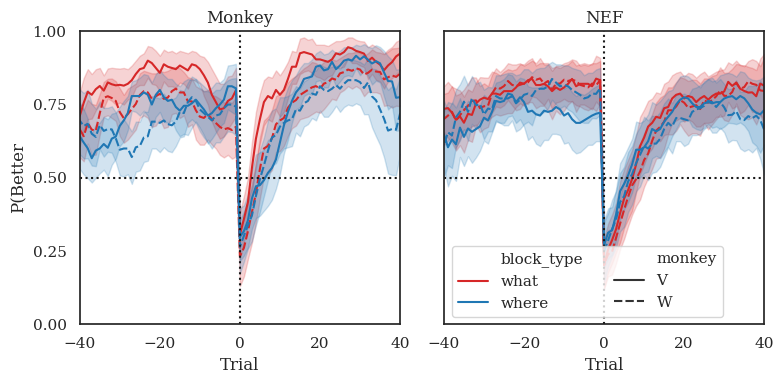

In [32]:
plot_dynamics(monkey_values, nef_values, y='acc', xlim=[-40,40], ylabel='P(Better')

/tmp/ipykernel_2685294/1485812486.py:5: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: smooth_split(g, y=y, ylabel=f'{y}_smooth'))[f'{y}_smooth'])
/tmp/ipykernel_2685294/1485812486.py:10: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: smooth_split(g, y=y, ylabel=f'{y}_smooth'))[f'{y}_smooth'])


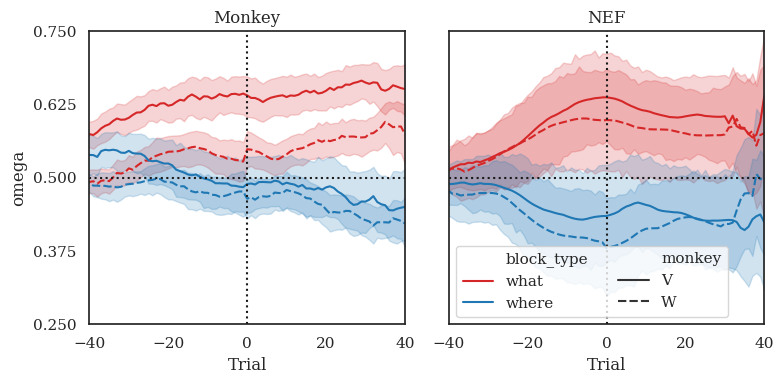

In [33]:
plot_dynamics(monkey_values, nef_values, y='omega', xlim=[-40,40], ylim=[0.25, 0.75], ylabel='omega')

# Plot fraction of Q_total vs omega

In [88]:
def plot_fraction_Qtotal(nef_values, rl_values):
    nef_w = nef_values['omega'].to_numpy()
    nef_dvs = np.abs(nef_values['va'].to_numpy() - nef_values['vb'].to_numpy())
    nef_dva = np.abs(nef_values['vl'].to_numpy() - nef_values['vr'].to_numpy())
    nef_p_stim = nef_dvs / (nef_dvs + nef_dva)
    nef_p_act = nef_dva / (nef_dvs + nef_dva)
    
    rl_w = rl_values['omega'].to_numpy()
    rl_dvs = np.abs(rl_values['DeltaV_Stim'].to_numpy())
    rl_dva = np.abs(rl_values['DeltaV_Act'].to_numpy())
    rl_p_stim = rl_dvs / (rl_dvs + rl_dva)
    rl_p_act = rl_dva / (rl_dvs + rl_dva)
    
    monkey_w = monkey_values['omega'].to_numpy()
    monkey_dvs = np.abs(monkey_values['DeltaV_Stim'].to_numpy())
    monkey_dva = np.abs(monkey_values['DeltaV_Act'].to_numpy())
    monkey_p_stim = monkey_dvs / (monkey_dvs + monkey_dva)
    monkey_p_act = monkey_dva / (monkey_dvs + monkey_dva)
    
    w_bins = np.linspace(0, 1, 20)
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(6,3), sharex=True, sharey=True)
    sns.regplot(x=rl_w, y=rl_p_stim, x_bins=w_bins, ax=axes[0], color=palette[0], scatter_kws={"s": 1}, label='RL')
    sns.regplot(x=rl_w, y=rl_p_act, x_bins=w_bins, ax=axes[1], color=palette[0], scatter_kws={"s": 1}, label='RL')
    sns.regplot(x=nef_w, y=nef_p_stim, x_bins=w_bins, ax=axes[0], color=palette[1], scatter_kws={"s": 1}, label='NEF')
    sns.regplot(x=nef_w, y=nef_p_act, x_bins=w_bins, ax=axes[1], color=palette[1], scatter_kws={"s": 1}, label='NEF')
    sns.regplot(x=monkey_w, y=monkey_p_stim, x_bins=w_bins, ax=axes[0], color=palette[2], scatter_kws={"s": 1}, label='Monkey')
    sns.regplot(x=monkey_w, y=monkey_p_act, x_bins=w_bins, ax=axes[1], color=palette[2], scatter_kws={"s": 1}, label='Monkey')
    axes[0].set(ylabel="Fraction of Q_total", xlim=(0.2, 0.8), ylim=(0, 1), title="Q_stim", xlabel='Omega')
    axes[1].set(xlim=(0.2, 0.8), ylim=(0, 1), title="Q_loc", xlabel='Omega')
    plt.tight_layout()

/tmp/ipykernel_2685294/3487888529.py:11: RuntimeWarning: invalid value encountered in divide
  rl_p_stim = rl_dvs / (rl_dvs + rl_dva)
/tmp/ipykernel_2685294/3487888529.py:12: RuntimeWarning: invalid value encountered in divide
  rl_p_act = rl_dva / (rl_dvs + rl_dva)


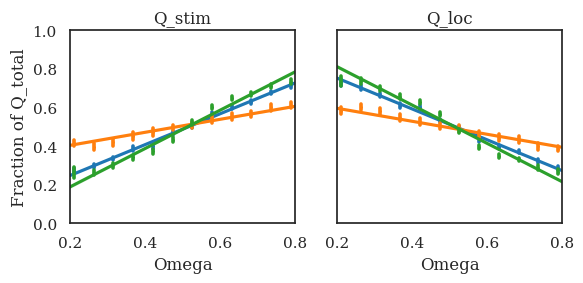

In [89]:
plot_fraction_Qtotal(nef_values, rl_values)

# Plot decoding acccuracy vs omega

In [141]:
def plot_decoding_accuracy_vs_omega(monkey_values, rl_values):
    """
    Bin omega values into 5 bins based on:
      ω₃: [0.45, 0.55]
      ω₁, ω₂: median split of values < 0.45
      ω₄, ω₅: median split of values > 0.55
    """
    omega = rl_values['omega']
    # masks
    mask_low = omega < 0.45
    mask_high = omega > 0.55
    mask_mid = (omega >= 0.45) & (omega <= 0.55)
    # compute medians for split
    med_low = omega[mask_low].median()
    med_high = omega[mask_high].median()
    # initialize column
    rl_values['omega_bin'] = np.nan
    # assign bins
    rl_values.loc[mask_low & (omega <= med_low), 'omega_bin'] = 1
    rl_values.loc[mask_low & (omega > med_low), 'omega_bin'] = 2
    rl_values.loc[mask_mid, 'omega_bin'] = 3
    rl_values.loc[mask_high & (omega <= med_high), 'omega_bin'] = 4
    rl_values.loc[mask_high & (omega > med_high), 'omega_bin'] = 5
    rl_values['omega_bin'] = rl_values['omega_bin'].astype(int)

    # Ensure both DataFrames align
    combined = pd.merge(
        rl_values[['monkey', 'session', 'block', 'trial', 'omega', 'omega_bin', 'DeltaV_Stim', 'DeltaV_Act']],
        monkey_values[['monkey', 'session', 'block', 'trial', 'DeltaV_Stim', 'DeltaV_Act']],
        on=['monkey', 'session', 'block', 'trial'],
        suffixes=('_rl', '_monkey')
    )

    palette = sns.color_palette("coolwarm", 5)
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(8,4), sharex=True, sharey=True)
    for w, omega_bin in enumerate([1,2,3,4,5]):
        # Filter data for this omega bin
        df_bin_act = combined.query("omega_bin==@omega_bin")[['DeltaV_Act_rl', 'DeltaV_Act_monkey']]
        df_bin_stim = combined.query("omega_bin==@omega_bin")[['DeltaV_Stim_rl', 'DeltaV_Stim_monkey']]
        # Compute R²
        r2_act = 1 - np.sum((df_bin_act['DeltaV_Act_monkey'] - df_bin_act['DeltaV_Act_rl'])**2) / \
                      np.sum((df_bin_act['DeltaV_Act_rl'] - df_bin_act['DeltaV_Act_rl'].mean())**2)
        r2_stim = 1 - np.sum((df_bin_stim['DeltaV_Stim_monkey'] - df_bin_stim['DeltaV_Stim_rl'])**2) / \
                       np.sum((df_bin_stim['DeltaV_Stim_rl'] - df_bin_stim['DeltaV_Stim_rl'].mean())**2)
        # Plot regression lines with confidence interval
        sns.regplot(data=df_bin_act, x='DeltaV_Act_rl', y='DeltaV_Act_monkey',
                    scatter=False, color=palette[w], ax=axes[0], 
                    label=rf"$\omega_{omega_bin}: R^2={r2_act:.2f}$")
        sns.regplot(data=df_bin_stim, x='DeltaV_Stim_rl', y='DeltaV_Stim_monkey',
                    scatter=False, color=palette[w], ax=axes[1],
                    label=rf"$\omega_{omega_bin}: R^2={r2_stim:.2f}$")
    axes[0].set(xlabel='RL value\n(ground truth)', ylabel='Monkey value\n(decoded from spikes)', title=r'$\Delta Q_{Act}$')
    axes[1].set(xlabel='RL value\n(ground truth)', ylabel=None, title=r'$\Delta Q_{Stim}$')
    axes[0].legend()
    axes[1].legend()
    plt.tight_layout()
    plt.show()

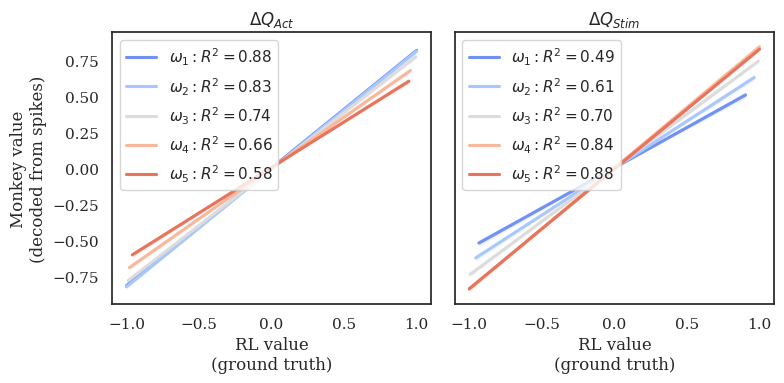

In [142]:
plot_decoding_accuracy_vs_omega(monkey_values, rl_values)

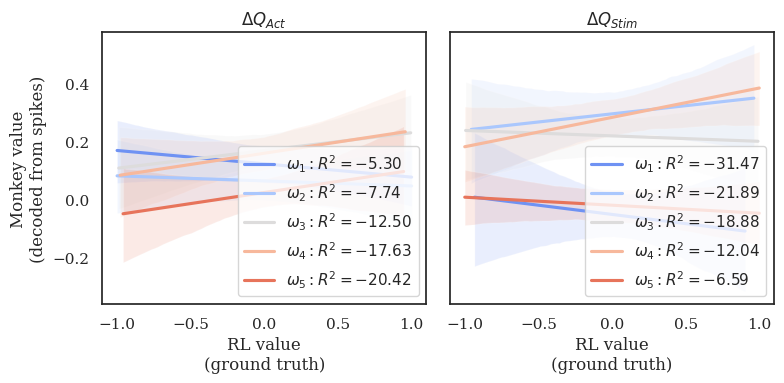

In [143]:
plot_decoding_accuracy_vs_omega(monkey_shuffled, rl_values)

# Decode DeltaQ and Choice, and plot Accuracy vs Omega

## Divide the rl_values dataframe into 5 equal dataframes, one for each quantile of omega

In [15]:
# Create a new column that indicates which quantile bin each row belongs to
# rl_values['omega_bin'] = pd.qcut(rl_values['omega'], q=6, labels=False)
# print(rl_values['omega_bin'].value_counts())
# print(rl_values.groupby('omega_bin')['omega'].agg(['min', 'max']))

In [16]:
# # Create a new column that indicates which quantile bin each row belongs to. Ensure 3 bins above omega=0.5 and 3 bins below
# for values in [rl_values, nef_values]:
#     df = values.copy()
#     mask_action = df['omega'] < 0.5
#     mask_stim = df['omega'] > 0.5
#     df['omega_bin'] = pd.Series([None] * len(df), dtype="object")
#     df.loc[mask_action, 'omega_bin'] = pd.qcut(df.loc[mask_action, 'omega'], q=3, labels=[1, 2, 3])
#     df.loc[mask_stim, 'omega_bin'] = pd.qcut(df.loc[mask_stim, 'omega'], q=3, labels=[4, 5, 6])
#     df['omega_bin'] = df['omega_bin'].astype(int)
#     print(df['omega_bin'].value_counts().sort_index())
#     print(df.groupby('omega_bin')['omega'].agg(['min', 'max']))
#     values['omega_bin'] = df['omega_bin']

In [17]:
# def regress_spikes_values_by_omega(rl_values, monkey_values, nef_values):
#     # build empty data dictionary
#     def empty_dictionary():
#         return defaultdict(lambda: defaultdict(lambda: defaultdict(list)))
#     cue_spike_data = empty_dictionary()
#     choice_spike_data = empty_dictionary()
#     nef_spike_data = empty_dictionary()
#     DeltaQ_Stim_data = empty_dictionary()
#     DeltaQ_Act_data = empty_dictionary()
#     chosen_Stim_data = empty_dictionary()
#     chosen_Act_data = empty_dictionary()
#     dvs_data = empty_dictionary()
#     dva_data = empty_dictionary()
#     cloc_data = empty_dictionary()
#     clet_data = empty_dictionary()
#     for rl_omega_bin in rl_values['omega_bin'].unique():
#         for monkey in ["V", "W"]:
#             for session in range(4):
#                 cue_spike_data[monkey][session][rl_omega_bin] = []
#                 choice_spike_data[monkey][session][rl_omega_bin] = []
#                 DeltaQ_Stim_data[monkey][session][rl_omega_bin] = []
#                 DeltaQ_Act_data[monkey][session][rl_omega_bin] = []
#                 chosen_Stim_data[monkey][session][rl_omega_bin] = []
#                 chosen_Act_data[monkey][session][rl_omega_bin] = []
#     for nef_omega_bin in nef_values['omega_bin'].unique():
#         for monkey in ["V", "W"]:
#             for session in range(4):
#                 nef_spike_data[monkey][session][nef_omega_bin] = []
#                 dvs_data[monkey][session][nef_omega_bin] = []
#                 dva_data[monkey][session][nef_omega_bin] = []
#                 cloc_data[monkey][session][nef_omega_bin] = []
#                 clet_data[monkey][session][nef_omega_bin] = []

#     # populate the data dictionary with spikes (X) and RL variables (Y)
#     for index, rl_row in rl_values.iterrows():
#         monkey_row = monkey_values.loc[index]
#         monkey, session, block, trial, rl_omega_bin = rl_row['monkey'], rl_row['session'], rl_row['block'], rl_row['trial'], rl_row['omega_bin']
#         file = f"data/emp/monkey{monkey}_session{session}_block{block}_trial{trial}"
#         cue_spike_data[monkey][session][rl_omega_bin].append(np.load(f"{file}_spikes_cue.npz")['spikes'])
#         choice_spike_data[monkey][session][rl_omega_bin].append(np.load(f"{file}_spikes_choice.npz")['spikes'])
#         DeltaQ_Act_data[monkey][session][rl_omega_bin].append(0 if rl_row['DeltaV_Act']>0 else 1)  # binary value
#         DeltaQ_Stim_data[monkey][session][rl_omega_bin].append(0 if rl_row['DeltaV_Stim']>0 else 1)  # binary value
#         chosen_Stim_data[monkey][session][rl_omega_bin].append(0 if monkey_row['clet']=='A' else 1)  # binary value
#         chosen_Act_data[monkey][session][rl_omega_bin].append(0 if monkey_row['cloc']==0 else 1)  # binary value
#     for index, nef_row in nef_values.iterrows():
#         nef_row = nef_values.loc[index]
#         monkey, session, block, trial, nef_omega_bin = nef_row['monkey'], nef_row['session'], nef_row['block'], nef_row['trial'], nef_row['omega_bin']
#         file = f"data/nef/monkey{monkey}_session{session}_block{block}"
#         with open(f"{file}_spikes.pkl", "rb") as f:
#             nef_spikes = pickle.load(f)
#         nef_spike_data[monkey][session][nef_omega_bin].append(nef_spikes[trial])
#         dvs_data[monkey][session][nef_omega_bin].append(0 if nef_row['dvs']>0 else 1)  # binary value
#         dva_data[monkey][session][nef_omega_bin].append(0 if nef_row['dva']>0 else 1)  # binary value
#         cloc_data[monkey][session][nef_omega_bin].append(0 if nef_row['clet']=='A' else 1)  # binary value
#         clet_data[monkey][session][nef_omega_bin].append(0 if nef_row['cloc']=='right' else 1)  # binary value

#     # run regression on each monkey, session, omega_bin, and variable
#     dfs = []
#     columns = ['model_type', 'omega_bin', 'monkey', 'session', 'variable', 'accuracy']
#     pipeline = make_pipeline(StandardScaler(), RidgeClassifier(alpha=1.0))
#     scoring = 'accuracy'
#     for rl_omega_bin in rl_values['omega_bin'].unique():
#         for monkey in ["V", "W"]:
#             for session in range(4):
#                 x_cue = np.array(cue_spike_data[monkey][session][rl_omega_bin])
#                 x_choice = np.array(choice_spike_data[monkey][session][rl_omega_bin])
#                 y_dqa = np.array(DeltaQ_Act_data[monkey][session][rl_omega_bin])
#                 y_dqs = np.array(DeltaQ_Stim_data[monkey][session][rl_omega_bin])
#                 y_cs = np.array(chosen_Stim_data[monkey][session][rl_omega_bin])
#                 y_ca = np.array(chosen_Act_data[monkey][session][rl_omega_bin])
#                 if x_cue.shape[0]>100 and x_choice.shape[0]>100 and y_dqa.shape[0]>100 and y_dqs.shape[0]>100:
#                     e_dqa = cross_val_score(pipeline, x_choice, y_dqa, cv=10, scoring=scoring)
#                     e_dqs = cross_val_score(pipeline, x_choice, y_dqs, cv=10, scoring=scoring)
#                     e_cs = cross_val_score(pipeline, x_cue, y_cs, cv=10, scoring=scoring)
#                     e_ca = cross_val_score(pipeline, x_cue, y_ca, cv=10, scoring=scoring)
#                     dfs.append(pd.DataFrame([['monkey', rl_omega_bin, monkey, session, "dqs", np.mean(e_dqs)]], columns=columns))
#                     dfs.append(pd.DataFrame([['monkey', rl_omega_bin, monkey, session, "dqa", np.mean(e_dqa)]], columns=columns))
#                     dfs.append(pd.DataFrame([['monkey', rl_omega_bin, monkey, session, "cs", np.mean(e_cs)]], columns=columns))
#                     dfs.append(pd.DataFrame([['monkey', rl_omega_bin, monkey, session, "ca", np.mean(e_ca)]], columns=columns))
#     for nef_omega_bin in nef_values['omega_bin'].unique():
#         for monkey in ["V", "W"]:
#             for session in range(4):
#                 x = np.array(nef_spike_data[monkey][session][nef_omega_bin])
#                 y_dqa = np.array(dvs_data[monkey][session][nef_omega_bin])
#                 y_dqs = np.array(dva_data[monkey][session][nef_omega_bin])
#                 y_cs = np.array(cloc_data[monkey][session][nef_omega_bin])
#                 y_ca = np.array(clet_data[monkey][session][nef_omega_bin])
#                 if x.shape[0]>100 and y_dqa.shape[0]>100 and y_dqs.shape[0]>100:
#                     e_dqa = cross_val_score(pipeline, x, y_dqa, cv=10, scoring=scoring)
#                     e_dqs = cross_val_score(pipeline, x, y_dqs, cv=10, scoring=scoring)
#                     e_cs = cross_val_score(pipeline, x, y_cs, cv=10, scoring=scoring)
#                     e_ca = cross_val_score(pipeline, x, y_ca, cv=10, scoring=scoring)
#                     dfs.append(pd.DataFrame([['nef', nef_omega_bin, monkey, session, "dqs", np.mean(e_dqs)]], columns=columns))
#                     dfs.append(pd.DataFrame([['nef', nef_omega_bin, monkey, session, "dqa", np.mean(e_dqa)]], columns=columns))
#                     dfs.append(pd.DataFrame([['nef', nef_omega_bin, monkey, session, "cs", np.mean(e_cs)]], columns=columns))
#                     dfs.append(pd.DataFrame([['nef', nef_omega_bin, monkey, session, "ca", np.mean(e_ca)]], columns=columns))
#     acc_data = pd.concat(dfs, ignore_index=True)
#     return acc_data

In [18]:
# cross_decoding_data = regress_spikes_values_by_omega(rl_values, monkey_values, nef_values)

In [19]:
# sns.set(context='notebook', style='white', rc={"font.family": "DejaVu Serif"})
# palette2 = sns.color_palette("coolwarm", 6)
# wbins = np.arange(1, 7)
# variables = ['dqa', 'dqs', 'ca', 'cs']
# titles = [r'Sign of $\Delta Q_{Act}$', 
#           r'Sign of $\Delta Q_{Stim}$', 
#           r'Chosen$_{Act}$', 
#           r'Chosen$_{Stim}$']

# fig, axes = plt.subplots(nrows=2, ncols=2, sharex=True, sharey=True, figsize=(7, 5))
# for ax, var, title in zip(axes.ravel(), variables, titles):
#     df_sub = cross_decoding_data.query(f"model_type=='monkey' & variable == '{var}'")
#     sns.pointplot(data=df_sub, x='omega_bin', y='accuracy', hue='omega_bin', palette=palette2, errorbar=('se', 2),
#         ax=ax, capsize=0.2, dodge=0.0, legend=False, linestyle='none',)
#     for line in ax.lines:
#         line.set_markersize(3)
#         line.set_linewidth(2)
#     ax.set_title(title)
#     ax.set_xticks(wbins - 1)  # adjust if omega_bin starts at 0
#     ax.set_xticklabels([f'ω$_{i}$' for i in wbins])
#     ax.set_xlim(-0.5, 5.5)
# axes[0][0].set_ylabel('Decoding Accuracy')
# axes[1][0].set_ylabel('Decoding Accuracy')
# axes[1][0].set_xlabel(None)
# axes[1][1].set_xlabel(None)

# plt.tight_layout()
# plt.show()
# fig.savefig("plots/monkey_cross_decoding_accuracy.pdf")

In [20]:
# fig, axes = plt.subplots(nrows=2, ncols=2, sharex=True, sharey=True, figsize=(7, 5))
# for ax, var, title in zip(axes.ravel(), variables, titles):
#     df_sub = cross_decoding_data.query(f"model_type=='nef' & variable == '{var}'")
#     sns.pointplot(data=df_sub, x='omega_bin', y='accuracy', hue='omega_bin', palette=palette2, errorbar=('se', 2),
#         ax=ax, capsize=0.2, dodge=0.0, legend=False, linestyle='none',)
#     for line in ax.lines:
#         line.set_markersize(3)
#         line.set_linewidth(2)
#     ax.set_title(title)
#     ax.set_xticks(wbins - 1)  # adjust if omega_bin starts at 0
#     ax.set_xticklabels([f'ω$_{i}$' for i in wbins])
#     ax.set_xlim(-0.5, 5.5)
# axes[0][0].set_ylabel('Decoding Accuracy')
# axes[1][0].set_ylabel('Decoding Accuracy')
# axes[1][0].set_xlabel(None)
# axes[1][1].set_xlabel(None)

# plt.tight_layout()
# plt.show()
# fig.savefig("plots/nef_cross_decoding_accuracy.pdf")

## Divide omega into 5 bins using Jae's new method, and compute cross-validated R2 in a continuous way

In [33]:
def bin_omega(df, omega_col='omega'):
    """
    Bin omega values into 5 bins based on:
      ω₃: [0.45, 0.55]
      ω₁, ω₂: median split of values < 0.45
      ω₄, ω₅: median split of values > 0.55
    Returns df with a new column 'omega_bin' (integer 1–5).
    """
    df = df.copy()
    omega = df[omega_col]

    # masks
    mask_low = omega < 0.45
    mask_high = omega > 0.55
    mask_mid = (omega >= 0.45) & (omega <= 0.55)

    # compute medians for split
    med_low = omega[mask_low].median()
    med_high = omega[mask_high].median()

    # initialize column
    df['omega_bin'] = np.nan

    # assign bins
    df.loc[mask_low & (omega <= med_low), 'omega_bin'] = 1
    df.loc[mask_low & (omega > med_low), 'omega_bin'] = 2
    df.loc[mask_mid, 'omega_bin'] = 3
    df.loc[mask_high & (omega <= med_high), 'omega_bin'] = 4
    df.loc[mask_high & (omega > med_high), 'omega_bin'] = 5

    df['omega_bin'] = df['omega_bin'].astype(int)
    return df

In [78]:
# rl_values = bin_omega(rl_values)
# nef_values = bin_omega(nef_values)
print(rl_values['omega_bin'].value_counts().sort_index())
print(rl_values.groupby('omega_bin')['omega'].agg(['min', 'max', 'median']))

omega_bin
1    2373
2    2372
3    3327
4    3564
5    3564
Name: count, dtype: int64
                min       max    median
omega_bin                              
1          0.093334  0.342442  0.284355
2          0.342496  0.449953  0.397995
3          0.450013  0.549924  0.502742
4          0.550039  0.680823  0.617950
5          0.680933  0.915490  0.739661


In [52]:
def regress_spikes_values_by_omega_continuous(rl_values, monkey_values, nef_values, cv=10, random_state=None):
    """
    Decode ΔQ (continuous, ridge regression) and choice (discrete, ridge classifier)
    from neural spikes, separated by monkey/session/omega_bin.
    Continuous targets use shuffle-corrected R².
    Discrete targets use accuracy.
    """
    
    # --- helper for nested dicts ---
    def empty_dictionary():
        return defaultdict(lambda: defaultdict(lambda: defaultdict(list)))
    
    # --- data containers ---
    cue_spike_data = empty_dictionary()
    choice_spike_data = empty_dictionary()
    nef_spike_data = empty_dictionary()
    DeltaQ_Stim_data = empty_dictionary()
    DeltaQ_Act_data = empty_dictionary()
    chosen_Stim_data = empty_dictionary()
    chosen_Act_data = empty_dictionary()
    dvs_data = empty_dictionary()
    dva_data = empty_dictionary()
    cloc_data = empty_dictionary()
    clet_data = empty_dictionary()

    # --- initialize keys ---
    for omega_bin in rl_values['omega_bin'].unique():
        for monkey in ["V", "W"]:
            for session in range(4):
                cue_spike_data[monkey][session][omega_bin] = []
                choice_spike_data[monkey][session][omega_bin] = []
                DeltaQ_Stim_data[monkey][session][omega_bin] = []
                DeltaQ_Act_data[monkey][session][omega_bin] = []
                chosen_Stim_data[monkey][session][omega_bin] = []
                chosen_Act_data[monkey][session][omega_bin] = []
    # for omega_bin in nef_values['omega_bin'].unique():
    #     for monkey in ["V", "W"]:
    #         for session in range(4):
    #             nef_spike_data[monkey][session][omega_bin] = []
    #             dvs_data[monkey][session][omega_bin] = []
    #             dva_data[monkey][session][omega_bin] = []
    #             cloc_data[monkey][session][omega_bin] = []
    #             clet_data[monkey][session][omega_bin] = []

    # --- populate data ---
    for index, rl_row in rl_values.iterrows():
        monkey_row = monkey_values.loc[index]
        monkey, session, block, trial, omega_bin = (
            rl_row['monkey'], rl_row['session'], rl_row['block'], rl_row['trial'], rl_row['omega_bin']
        )
        file = f"data/emp/monkey{monkey}_session{session}_block{block}_trial{trial}"
        cue_spike_data[monkey][session][omega_bin].append(np.load(f"{file}_spikes_cue.npz")['spikes'])
        choice_spike_data[monkey][session][omega_bin].append(np.load(f"{file}_spikes_choice.npz")['spikes'])
        # continuous values
        DeltaQ_Act_data[monkey][session][omega_bin].append(rl_row['DeltaV_Act'])
        DeltaQ_Stim_data[monkey][session][omega_bin].append(rl_row['DeltaV_Stim'])
        # discrete choices
        chosen_Stim_data[monkey][session][omega_bin].append(0 if monkey_row['clet']=='A' else 1)
        chosen_Act_data[monkey][session][omega_bin].append(0 if monkey_row['cloc']==0 else 1)

    # for index, nef_row in nef_values.iterrows():
    #     monkey, session, block, trial, omega_bin = (
    #         nef_row['monkey'], nef_row['session'], nef_row['block'], nef_row['trial'], nef_row['omega_bin']
    #     )
    #     file = f"data/nef/monkey{monkey}_session{session}_block{block}"
    #     with open(f"{file}_spikes.pkl", "rb") as f:
    #         nef_spikes = pickle.load(f)
    #     nef_spike_data[monkey][session][omega_bin].append(nef_spikes[trial])
    #     # continuous
    #     dvs_data[monkey][session][omega_bin].append(nef_row['dvs'])
    #     dva_data[monkey][session][omega_bin].append(nef_row['dva'])
    #     # discrete
    #     cloc_data[monkey][session][omega_bin].append(0 if nef_row['clet']=='A' else 1)
    #     clet_data[monkey][session][omega_bin].append(0 if nef_row['cloc']=='right' else 1)

    # --- helper: shuffle-corrected R² ---
    def compute_shuffle_corrected_r2(X, y, cv=10, random_state=None):
        pipeline = make_pipeline(StandardScaler(), Ridge(alpha=1.0))
        r2_true = np.mean(cross_val_score(pipeline, X, y, cv=cv, scoring='r2'))
        X_shuf = X.copy()
        rng = np.random.default_rng(random_state)
        rng.shuffle(X_shuf, axis=0)
        r2_shuf = np.mean(cross_val_score(pipeline, X_shuf, y, cv=cv, scoring='r2'))
        # r2_corr = 1 - r2_true/r2_shuf
        # r2_corr = r2_true - r2_shuf
        r2_corr = (r2_true - r2_shuf) / (1 - r2_shuf) if r2_shuf < 1 else r2_true - r2_shuf  # Corrected R² (bounded between -∞, 1]
        return r2_true, r2_shuf, r2_corr

    # --- discrete classifier pipeline ---
    clf_pipeline = make_pipeline(StandardScaler(), RidgeClassifier(alpha=1.0))

    # --- run decoding ---
    dfs = []
    columns = ['model_type', 'omega_bin', 'monkey', 'session', 'variable', 'accuracy']

    for omega_bin in rl_values['omega_bin'].unique():
        for monkey in ["V", "W"]:
            for session in range(4):
                x_cue = np.array(cue_spike_data[monkey][session][omega_bin])
                x_choice = np.array(choice_spike_data[monkey][session][omega_bin])
                y_dqa = np.array(DeltaQ_Act_data[monkey][session][omega_bin])
                y_dqs = np.array(DeltaQ_Stim_data[monkey][session][omega_bin])
                y_cs = np.array(chosen_Stim_data[monkey][session][omega_bin])
                y_ca = np.array(chosen_Act_data[monkey][session][omega_bin])
                if len(x_cue) > 0 and len(x_choice) > 100:
                    # continuous R²
                    _, _, r2corr_dqa = compute_shuffle_corrected_r2(x_choice, y_dqa, cv=cv)
                    _, _, r2corr_dqs = compute_shuffle_corrected_r2(x_choice, y_dqs, cv=cv)
                    # discrete accuracy
                    acc_cs = np.mean(cross_val_score(clf_pipeline, x_cue, y_cs, cv=cv, scoring='accuracy'))
                    acc_ca = np.mean(cross_val_score(clf_pipeline, x_cue, y_ca, cv=cv, scoring='accuracy'))
                    # store
                    dfs.append(pd.DataFrame([['monkey', omega_bin, monkey, session, 'dqs', r2corr_dqs]], columns=columns))
                    dfs.append(pd.DataFrame([['monkey', omega_bin, monkey, session, 'dqa', r2corr_dqa]], columns=columns))
                    dfs.append(pd.DataFrame([['monkey', omega_bin, monkey, session, 'cs', acc_cs]], columns=columns))
                    dfs.append(pd.DataFrame([['monkey', omega_bin, monkey, session, 'ca', acc_ca]], columns=columns))

    # for omega_bin in nef_values['omega_bin'].unique():
    #     for monkey in ["V", "W"]:
    #         for session in range(4):
    #             x = np.array(nef_spike_data[monkey][session][omega_bin])
    #             y_dqa = np.array(dvs_data[monkey][session][omega_bin])
    #             y_dqs = np.array(dva_data[monkey][session][omega_bin])
    #             y_cs = np.array(cloc_data[monkey][session][omega_bin])
    #             y_ca = np.array(clet_data[monkey][session][omega_bin])
    #             if len(x) > 0 and len(y_dqs) > 0:
    #                 # continuous R²
    #                 _, _, r2corr_dqa = compute_shuffle_corrected_r2(x, y_dqa, cv=cv)
    #                 _, _, r2corr_dqs = compute_shuffle_corrected_r2(x, y_dqs, cv=cv)
    #                 # discrete accuracy
    #                 acc_cs = np.mean(cross_val_score(clf_pipeline, x, y_cs, cv=cv, scoring='accuracy'))
    #                 acc_ca = np.mean(cross_val_score(clf_pipeline, x, y_ca, cv=cv, scoring='accuracy'))
    #                 # store
    #                 dfs.append(pd.DataFrame([['nef', omega_bin, monkey, session, 'dqs', r2corr_dqs]], columns=columns))
    #                 dfs.append(pd.DataFrame([['nef', omega_bin, monkey, session, 'dqa', r2corr_dqa]], columns=columns))
    #                 dfs.append(pd.DataFrame([['nef', omega_bin, monkey, session, 'cs', acc_cs]], columns=columns))
    #                 dfs.append(pd.DataFrame([['nef', omega_bin, monkey, session, 'ca', acc_ca]], columns=columns))

    acc_data = pd.concat(dfs, ignore_index=True)
    return acc_data

In [53]:
acc_data_continuous = regress_spikes_values_by_omega_continuous(rl_values, monkey_values, nef_values)

In [75]:
def plot_decoding_accuracy(acc_data, model_type,
                           variables=['dqa', 'dqs'], titles=[r'$\Delta Q_{Act}$', r'$\Delta Q_{Stim}$'], ylim=[0,1]):
    palette2 = sns.color_palette("coolwarm", 5)
    wbins = np.arange(1, 6)
    fig1, axes1 = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(7, 3))
    for ax, var, title in zip(axes1, variables, titles):
        df_sub = acc_data.query(f"model_type == @model_type & variable == '{var}'")
        sns.pointplot(
            data=df_sub, x='omega_bin', y='accuracy',
            hue='omega_bin', palette=palette2,
            errorbar=('se', 2), capsize=0.2, dodge=0.0,
            legend=False, linestyle='none', ax=ax)
        for line in ax.lines:
            line.set_markersize(3)
            line.set_linewidth(2)
        ax.set_title(title)
        ax.set_xticks(np.arange(0, len(wbins)))
        ax.set_xticklabels([f'ω$_{{{i}}}$' for i in wbins])
        ax.set_xlim(-0.5, len(wbins) - 0.5)
        ax.set_ylim(ylim)
        ax.grid(False)
    axes1[0].set_ylabel('Decoding Accuracy\n(Continuous Cross-val)')
    axes1[0].set(xlabel=None)
    axes1[1].set(xlabel=None)
    fig1.tight_layout()
    plt.show()
    fig1.savefig("plots/monkey_cross_decoding_accuracy_continuous.pdf")

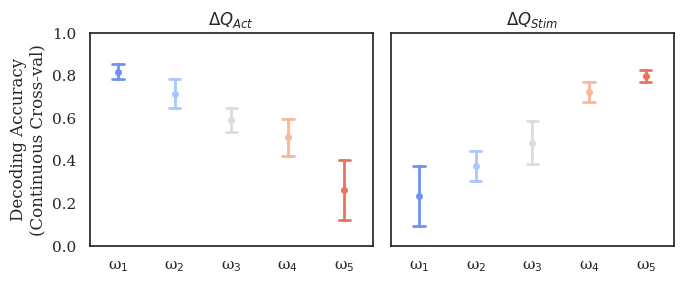

In [76]:
plot_decoding_accuracy(acc_data_continuous, model_type='monkey')

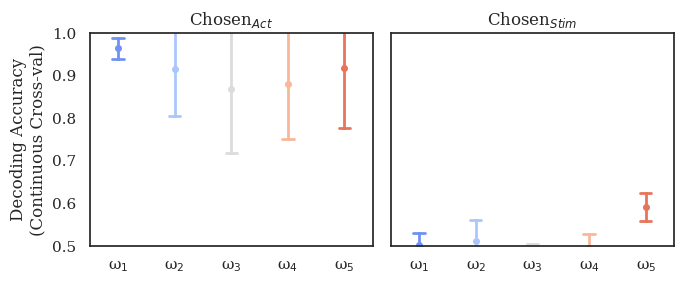

In [77]:
plot_decoding_accuracy(acc_data_continuous, model_type='monkey',
                       variables=['ca', 'cs'], titles=[r'Chosen$_{Act}$', r'Chosen$_{Stim}$'], ylim=[0.5,1])